In [1]:
%matplotlib

Using matplotlib backend: MacOSX


In [2]:

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
sns.set_palette('colorblind')
sns.set_style('white')

In [39]:
import pandas as pd
import nltk
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.preprocessing import LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import SGDClassifier

In [13]:
df = pd.read_csv('newtrain.csv')
df.head()

,Category,Text
0,5,why are yawns contagious? when people yawn
1,6,what is trans fat? how to reduce that? i heard...
2,1,roth ira vs 401k? what is the difference betwe...
3,1,how many planes fedex has? i heard that it is ...
4,2,what is the best photo slideshow creation appl...


In [14]:
#tokenize text
pattern = r'''(?x)    # set flag to allow verbose regexps
     ([A-Z]\.)+        # abbreviations, e.g. U.S.A.
   | \w+([-']\w+)*        # words with optional internal hyphens
   | \$?\d+(\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
   | \.\.\.            # ellipsis
   | [.,;"?():-_`]+  # these are separate tokens
 '''

tokenize = lambda text: nltk.regexp_tokenize(text, pattern)
df['Text'] = df['Text'].apply(tokenize)

In [15]:
df.head()

,Category,Text
0,5,"[why, are, yawns, contagious, ?, when, people,..."
1,6,"[what, is, trans, fat, ?, how, to, reduce, tha..."
2,1,"[roth, ira, vs, 401k, ?, what, is, the, differ..."
3,1,"[how, many, planes, fedex, has, ?, i, heard, t..."
4,2,"[what, is, the, best, photo, slideshow, creati..."


In [16]:
#remove punctuation, stopwords
rem_chars = [p for p in string.punctuation] + list(ENGLISH_STOP_WORDS)
#rem_chars = [p for p in string.punctuation]
rem = lambda a: ' '.join([i for i in a if i not in rem_chars])
#rem = lambda a: [i for i in a if i not in rem_chars]
df['Text'] = df['Text'].apply(rem)


In [17]:
df.head()

,Category,Text
0,5,yawns contagious people yawn
1,6,trans fat reduce heard tras fat bad body daily...
2,1,roth ira vs 401k difference roth ira 401k prefer
3,1,planes fedex heard largest airline world
4,2,best photo slideshow creation application best...


In [18]:
df.Text.iloc[7]

'lin qingxia aka brigitte lin beautiful woman chinese cinema according stephen chow http www hkentreview com 2005 features kfh kfhprem html ). true best-looking male star did make movies'

In [50]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss = 'hinge',penalty = 'L2'))])

text_clf = text_clf.fit(df['Text'],df['Category'])

In [51]:
from sklearn.grid_search import GridSearchCV
#grid search params
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], #either uni or bigrams
               'tfidf__use_idf': (True, False), #use or don't use idf
               'clf__alpha': (1e-2, 1e-3)} #with different penalty params for linear svm

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1) #fit grid search instance

gs_clf = gs_clf.fit(counts[tr], targets[tr]) #fit on one cv fold

best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1]) #find best params

JoblibAttributeError: JoblibAttributeError
___________________________________________________________________________
Multiprocessing exception:
    ...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/runpy.py in _run_module_as_main(mod_name='IPython.kernel.__main__', alter_argv=1)
    155     pkg_name = mod_name.rpartition('.')[0]
    156     main_globals = sys.modules["__main__"].__dict__
    157     if alter_argv:
    158         sys.argv[0] = fname
    159     return _run_code(code, main_globals, None,
--> 160                      "__main__", fname, loader, pkg_name)
        fname = '/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/__main__.py'
        loader = <_frozen_importlib.SourceFileLoader object>
        pkg_name = 'IPython.kernel'
    161 
    162 def run_module(mod_name, init_globals=None,
    163                run_name=None, alter_sys=False):
    164     """Execute a module's code without importing it

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/runpy.py in _run_code(code=<code object <module> at 0x10071bb70, file "/Use...ite-packages/IPython/kernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': None, '__doc__': None, '__file__': '/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/__main__.py', '__loader__': <_frozen_importlib.SourceFileLoader object>, '__name__': '__main__', '__package__': 'IPython.kernel', 'app': <module 'IPython.kernel.zmq.kernelapp' from '/Us...3/site-packages/IPython/kernel/zmq/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_fname='/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/__main__.py', mod_loader=<_frozen_importlib.SourceFileLoader object>, pkg_name='IPython.kernel')
     68                        __file__ = mod_fname,
     69                        __cached__ = None,
     70                        __doc__ = None,
     71                        __loader__ = mod_loader,
     72                        __package__ = pkg_name)
---> 73     exec(code, run_globals)
        code = <code object <module> at 0x10071bb70, file "/Use...ite-packages/IPython/kernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': None, '__doc__': None, '__file__': '/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/__main__.py', '__loader__': <_frozen_importlib.SourceFileLoader object>, '__name__': '__main__', '__package__': 'IPython.kernel', 'app': <module 'IPython.kernel.zmq.kernelapp' from '/Us...3/site-packages/IPython/kernel/zmq/kernelapp.py'>}
     74     return run_globals
     75 
     76 def _run_module_code(code, init_globals=None,
     77                     mod_name=None, mod_fname=None,

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from IPython.kernel.zmq import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/config/application.py in launch_instance(cls=<class 'IPython.kernel.zmq.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    569         
    570         If a global instance already exists, this reinitializes and starts it
    571         """
    572         app = cls.instance(**kwargs)
    573         app.initialize(argv)
--> 574         app.start()
        app.start = <bound method IPKernelApp.start of <IPython.kernel.zmq.kernelapp.IPKernelApp object>>
    575 
    576 #-----------------------------------------------------------------------------
    577 # utility functions, for convenience
    578 #-----------------------------------------------------------------------------

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/zmq/kernelapp.py in start(self=<IPython.kernel.zmq.kernelapp.IPKernelApp object>)
    368     def start(self):
    369         if self.poller is not None:
    370             self.poller.start()
    371         self.kernel.start()
    372         try:
--> 373             ioloop.IOLoop.instance().start()
    374         except KeyboardInterrupt:
    375             pass
    376 
    377 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    146             PollIOLoop.configure(ZMQIOLoop)
    147         return PollIOLoop.instance()
    148     
    149     def start(self):
    150         try:
--> 151             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    152         except ZMQError as e:
    153             if e.errno == ETERM:
    154                 # quietly return on ETERM
    155                 pass

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    805                         self._timeouts = [x for x in self._timeouts
    806                                           if x.callback is not None]
    807                         heapq.heapify(self._timeouts)
    808 
    809                 for callback in callbacks:
--> 810                     self._run_callback(callback)
        self._run_callback = <bound method ZMQIOLoop._run_callback of <zmq.eventloop.ioloop.ZMQIOLoop object>>
        callback = functools.partial(<function wrap.<locals>.null_wrapper at 0x1068c6cb0>)
    811                 for timeout in due_timeouts:
    812                     if timeout.callback is not None:
    813                         self._run_callback(timeout.callback)
    814                 # Closures may be holding on to a lot of memory, so allow

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/tornado/ioloop.py in _run_callback(self=<zmq.eventloop.ioloop.ZMQIOLoop object>, callback=functools.partial(<function wrap.<locals>.null_wrapper at 0x1068c6cb0>))
    587         """Runs a callback with error handling.
    588 
    589         For use in subclasses.
    590         """
    591         try:
--> 592             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_wrapper at 0x1068c6cb0>)
    593             if ret is not None and is_future(ret):
    594                 # Functions that return Futures typically swallow all
    595                 # exceptions and store them in the Future.  If a Future
    596                 # makes it out to the IOLoop, ensure its exception (if any)

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/tornado/stack_context.py in null_wrapper(*args=(), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ()
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/zmq/kernelbase.py in enter_eventloop(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>)
    229             stream.flush(zmq.POLLOUT)
    230         # restore default_int_handler
    231         signal(SIGINT, default_int_handler)
    232         while self.eventloop is not None:
    233             try:
--> 234                 self.eventloop(self)
        self.eventloop = None
        self = <IPython.kernel.zmq.ipkernel.IPythonKernel object>
    235             except KeyboardInterrupt:
    236                 # Ctrl-C shouldn't crash the kernel
    237                 self.log.error("KeyboardInterrupt caught in kernel")
    238                 continue

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/zmq/eventloops.py in loop_cocoa(kernel=<IPython.kernel.zmq.ipkernel.IPythonKernel object>)
    246                 show.mainloop()
    247                 sys.excepthook = real_excepthook
    248                 # use poller if mainloop returned (no windows)
    249                 # scale by extra factor of 10, since it's a real poll
    250                 poller.poll(10*poll_interval)
--> 251                 kernel.do_one_iteration()
        kernel.do_one_iteration = <bound method IPythonKernel.do_one_iteration of <IPython.kernel.zmq.ipkernel.IPythonKernel object>>
    252             except:
    253                 raise
    254         except KeyboardInterrupt:
    255             # Ctrl-C shouldn't crash the kernel

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/zmq/kernelbase.py in do_one_iteration(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>)
    262         """step eventloop just once"""
    263         if self.control_stream:
    264             self.control_stream.flush()
    265         for stream in self.shell_streams:
    266             # handle at most one request per iteration
--> 267             stream.flush(zmq.POLLIN, 1)
        stream.flush = <bound method ZMQStream.flush of <zmq.eventloop.zmqstream.ZMQStream object>>
    268             stream.flush(zmq.POLLOUT)
    269 
    270 
    271     def record_ports(self, ports):

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/zmq/eventloop/zmqstream.py in flush(self=<zmq.eventloop.zmqstream.ZMQStream object>, flag=1, limit=1)
    340         self.poller.register(self.socket, flag)
    341         events = self.poller.poll(0)
    342         while events and (not limit or count < limit):
    343             s,event = events[0]
    344             if event & zmq.POLLIN: # receiving
--> 345                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    346                 count += 1
    347                 if self.socket is None:
    348                     # break if socket was closed during callback
    349                     break

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    460                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    461         else:
    462             if self._recv_callback:
    463                 callback = self._recv_callback
    464                 # self._recv_callback = None
--> 465                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    466                 
    467         # self.update_state()
    468         
    469 

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    402         close our socket."""
    403         try:
    404             # Use a NullContext to ensure that all StackContexts are run
    405             # inside our blanket exception handler rather than outside.
    406             with stack_context.NullContext():
--> 407                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    408         except:
    409             gen_log.error("Uncaught exception, closing connection.",
    410                           exc_info=True)
    411             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/zmq/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    247         if self.control_stream:
    248             self.control_stream.on_recv(self.dispatch_control, copy=False)
    249 
    250         def make_dispatcher(stream):
    251             def dispatcher(msg):
--> 252                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    253             return dispatcher
    254 
    255         for s in self.shell_streams:
    256             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/zmq/kernelbase.py in dispatch_shell(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.grid_search import GridSearchCV\n#gr...id_scores_, key=lambda x: x[1]) #find best params', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'msg_id': '557B192CAFD240ED8275FE1EDE95C109', 'msg_type': 'execute_request', 'session': 'E745F92131DB4300A3ABC50EDE026100', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '557B192CAFD240ED8275FE1EDE95C109', 'msg_type': 'execute_request', 'parent_header': {}})
    208         else:
    209             # ensure default_int_handler during handler call
    210             sig = signal(SIGINT, default_int_handler)
    211             self.log.debug("%s: %s", msg_type, msg)
    212             try:
--> 213                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <IPython.kernel.zmq.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'E745F92131DB4300A3ABC50EDE026100']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.grid_search import GridSearchCV\n#gr...id_scores_, key=lambda x: x[1]) #find best params', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'msg_id': '557B192CAFD240ED8275FE1EDE95C109', 'msg_type': 'execute_request', 'session': 'E745F92131DB4300A3ABC50EDE026100', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '557B192CAFD240ED8275FE1EDE95C109', 'msg_type': 'execute_request', 'parent_header': {}}
    214             except Exception:
    215                 self.log.error("Exception in message handler:", exc_info=True)
    216             finally:
    217                 signal(SIGINT, sig)

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/zmq/kernelbase.py in execute_request(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'E745F92131DB4300A3ABC50EDE026100'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.grid_search import GridSearchCV\n#gr...id_scores_, key=lambda x: x[1]) #find best params', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'msg_id': '557B192CAFD240ED8275FE1EDE95C109', 'msg_type': 'execute_request', 'session': 'E745F92131DB4300A3ABC50EDE026100', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '557B192CAFD240ED8275FE1EDE95C109', 'msg_type': 'execute_request', 'parent_header': {}})
    357         if not silent:
    358             self.execution_count += 1
    359             self._publish_execute_input(code, parent, self.execution_count)
    360         
    361         reply_content = self.do_execute(code, silent, store_history,
--> 362                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    363 
    364         # Flush output before sending the reply.
    365         sys.stdout.flush()
    366         sys.stderr.flush()

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/zmq/ipkernel.py in do_execute(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, code='from sklearn.grid_search import GridSearchCV\n#gr...id_scores_, key=lambda x: x[1]) #find best params', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    176 
    177         reply_content = {}
    178         # FIXME: the shell calls the exception handler itself.
    179         shell._reply_content = None
    180         try:
--> 181             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <I....kernel.zmq.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.grid_search import GridSearchCV\n#gr...id_scores_, key=lambda x: x[1]) #find best params'
        store_history = True
        silent = False
    182         except:
    183             status = u'error'
    184             # FIXME: this code right now isn't being used yet by default,
    185             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/core/interactiveshell.py in run_cell(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.grid_search import GridSearchCV\n#gr...id_scores_, key=lambda x: x[1]) #find best params', store_history=True, silent=False, shell_futures=True)
   2866                 self.displayhook.exec_result = result
   2867 
   2868                 # Execute the user code
   2869                 interactivity = "none" if silent else self.ast_node_interactivity
   2870                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2871                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2872 
   2873                 # Reset this so later displayed values do not modify the
   2874                 # ExecutionResult
   2875                 self.displayhook.exec_result = None

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-51-9f63e958eb52>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2970 
   2971         try:
   2972             for i, node in enumerate(to_run_exec):
   2973                 mod = ast.Module([node])
   2974                 code = compiler(mod, cell_name, "exec")
-> 2975                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <I....kernel.zmq.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x10be164b0, file "<ipython-input-51-9f63e958eb52>", line 9>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2976                     return True
   2977 
   2978             for i, node in enumerate(to_run_interactive):
   2979                 mod = ast.Interactive([node])

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/core/interactiveshell.py in run_code(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x10be164b0, file "<ipython-input-51-9f63e958eb52>", line 9>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3030         outflag = 1  # happens in more places, so it's easier as default
   3031         try:
   3032             try:
   3033                 self.hooks.pre_run_code_hook()
   3034                 #rprint('Running code', repr(code_obj)) # dbg
-> 3035                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x10be164b0, file "<ipython-input-51-9f63e958eb52>", line 9>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'ENGLISH_STOP_WORDS': frozenset(['a', 'about', 'above', 'across', 'after', 'afterwards', ...]), 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', "get_ipython().magic('matplotlib')", "\nimport seaborn as sns\nfrom matplotlib import py....set_palette('colorblind')\nsns.set_style('white')", 'import pandas as pd\nimport nltk\nimport string\n\nf...B\nfrom sklearn.tree import DecisionTreeClassifier', 'import pandas as pd\nimport nltk\nimport string\n\nf...B\nfrom sklearn.tree import DecisionTreeClassifier', 'import pandas as pd\nimport nltk\nimport string\n\nf...B\nfrom sklearn.tree import DecisionTreeClassifier', "df = pd.read_csv('newtrain.csv')\ndf.head()", "#tokenize text\npattern = r'''(?x)    # set flag ... pattern)\ndf['Text'] = df['Text'].apply(tokenize)", 'df.head()', "#remove punctuation, stopwords\n#rem_chars = [p f... in rem_chars]\ndf['Text'] = df['Text'].apply(rem)", 'df.head()', "#remove punctuation, stopwords\nrem_chars = [p fo... in rem_chars]\ndf['Text'] = df['Text'].apply(rem)", 'df.head()', "df = pd.read_csv('newtrain.csv')\ndf.head()", "#tokenize text\npattern = r'''(?x)    # set flag ... pattern)\ndf['Text'] = df['Text'].apply(tokenize)", 'df.head()', "#remove punctuation, stopwords\nrem_chars = [p fo... in rem_chars]\ndf['Text'] = df['Text'].apply(rem)", 'df.head()', 'df.Text.iloc[7]', "#vectorize data\n#turns words into a list of vect...s = 1000)\ncounts = vec.fit_transform(df['Text']) ", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {6:    Category                                     ...w h t   s   t h e   b e s t   p h o t o   s l ..., 8:    Category                                     ...w h t   s   t h e   b e s t   p h o t o   s l ..., 10:    Category                                     ...w h t   s   t h e   b e s t   p h o t o   s l ..., 12:    Category                                     ...w h t   s   t h e   b e s t   p h o t o   s l ..., 13:    Category                                     ...best photo slideshow creation application best..., 15:    Category                                     ...best photo slideshow creation application best..., 17:    Category                                     ...best photo slideshow creation application best..., 18: 'lin qingxia aka brigitte lin beautiful woman chi...ml ). true best-looking male star did make movies', 22: <2698x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, 23: (2698, 1000), ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'ENGLISH_STOP_WORDS': frozenset(['a', 'about', 'above', 'across', 'after', 'afterwards', ...]), 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', "get_ipython().magic('matplotlib')", "\nimport seaborn as sns\nfrom matplotlib import py....set_palette('colorblind')\nsns.set_style('white')", 'import pandas as pd\nimport nltk\nimport string\n\nf...B\nfrom sklearn.tree import DecisionTreeClassifier', 'import pandas as pd\nimport nltk\nimport string\n\nf...B\nfrom sklearn.tree import DecisionTreeClassifier', 'import pandas as pd\nimport nltk\nimport string\n\nf...B\nfrom sklearn.tree import DecisionTreeClassifier', "df = pd.read_csv('newtrain.csv')\ndf.head()", "#tokenize text\npattern = r'''(?x)    # set flag ... pattern)\ndf['Text'] = df['Text'].apply(tokenize)", 'df.head()', "#remove punctuation, stopwords\n#rem_chars = [p f... in rem_chars]\ndf['Text'] = df['Text'].apply(rem)", 'df.head()', "#remove punctuation, stopwords\nrem_chars = [p fo... in rem_chars]\ndf['Text'] = df['Text'].apply(rem)", 'df.head()', "df = pd.read_csv('newtrain.csv')\ndf.head()", "#tokenize text\npattern = r'''(?x)    # set flag ... pattern)\ndf['Text'] = df['Text'].apply(tokenize)", 'df.head()', "#remove punctuation, stopwords\nrem_chars = [p fo... in rem_chars]\ndf['Text'] = df['Text'].apply(rem)", 'df.head()', 'df.Text.iloc[7]', "#vectorize data\n#turns words into a list of vect...s = 1000)\ncounts = vec.fit_transform(df['Text']) ", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {6:    Category                                     ...w h t   s   t h e   b e s t   p h o t o   s l ..., 8:    Category                                     ...w h t   s   t h e   b e s t   p h o t o   s l ..., 10:    Category                                     ...w h t   s   t h e   b e s t   p h o t o   s l ..., 12:    Category                                     ...w h t   s   t h e   b e s t   p h o t o   s l ..., 13:    Category                                     ...best photo slideshow creation application best..., 15:    Category                                     ...best photo slideshow creation application best..., 17:    Category                                     ...best photo slideshow creation application best..., 18: 'lin qingxia aka brigitte lin beautiful woman chi...ml ). true best-looking male star did make movies', 22: <2698x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, 23: (2698, 1000), ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, ...}
   3036             finally:
   3037                 # Reset our crash handler in place
   3038                 sys.excepthook = old_excepthook
   3039         except SystemExit as e:

...........................................................................
/Users/matar/Documents/Courses/NLP/HW/Text_Classification/<ipython-input-51-9f63e958eb52> in <module>()
      4                'tfidf__use_idf': (True, False), #use or don't use idf
      5                'clf__alpha': (1e-2, 1e-3)} #with different penalty params for linear svm
      6 
      7 gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1) #fit grid search instance
      8 
----> 9 gs_clf = gs_clf.fit(counts[tr], targets[tr]) #fit on one cv fold
     10 
     11 best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1]) #find best params
     12 
     13 

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ... score_func=None, scoring=None,
       verbose=0), X=<2428x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=array([2, 0, 0, ..., 5, 2, 1]))
    727         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    728             Target relative to X for classification or regression;
    729             None for unsupervised learning.
    730 
    731         """
--> 732         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method GridSearchCV._fit of GridSearchCV(...score_func=None, scoring=None,
       verbose=0)>
        X = <2428x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>
        y = array([2, 0, 0, ..., 5, 2, 1])
        self.param_grid = {'clf__alpha': (0.01, 0.001), 'tfidf__use_idf': (True, False), 'vect__ngram_range': [(1, 1), (1, 2)]}
    733 
    734 
    735 class RandomizedSearchCV(BaseSearchCV):
    736     """Randomized search on hyper parameters.

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=None, error_score='raise',
     ... score_func=None, scoring=None,
       verbose=0), X=<2428x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=array([2, 0, 0, ..., 5, 2, 1]), parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    500         )(
    501             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    502                                     train, test, self.verbose, parameters,
    503                                     self.fit_params, return_parameters=True,
    504                                     error_score=self.error_score)
--> 505                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    506                 for train, test in cv)
    507 
    508         # Out is a list of triplet: score, estimator, n_test_samples
    509         n_fits = len(out)

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<itertools.islice object>)
    661             if pre_dispatch == "all" or n_jobs == 1:
    662                 # The iterable was consumed all at once by the above for loop.
    663                 # No need to wait for async callbacks to trigger to
    664                 # consumption.
    665                 self._iterating = False
--> 666             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    667             # Make sure that we get a last message telling us we are done
    668             elapsed_time = time.time() - self._start_time
    669             self._print('Done %3i out of %3i | elapsed: %s finished',
    670                         (len(self._output),

    ---------------------------------------------------------------------------
    Sub-process traceback:
    ---------------------------------------------------------------------------
    AttributeError                                     Mon Oct 19 09:46:54 2015
PID: 8857          Python 3.3.5: /Users/matar/anaconda/envs/py3k/bin/python
...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=Pipeline(steps=[('vect', CountVectorizer(analyze...ffle=True,
       verbose=0, warm_start=False))]), X=<2428x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=array([2, 0, 0, ..., 5, 2, 1]), scorer=<function _passthrough_scorer>, train=array([ 714,  739,  750, ..., 2425, 2426, 2427]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 832, 835,
       836, 837, 838, 847, 854, 862]), verbose=0, parameters={'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1454 
   1455     try:
   1456         if y_train is None:
   1457             estimator.fit(X_train, **fit_params)
   1458         else:
-> 1459             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(steps=[('...fle=True,
       verbose=0, warm_start=False))])>
        X_train = <1616x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>
        y_train = array([5, 4, 5, ..., 5, 2, 1])
        fit_params = {}
   1460 
   1461     except Exception as e:
   1462         if error_score == 'raise':
   1463             raise

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/sklearn/pipeline.py in fit(self=Pipeline(steps=[('vect', CountVectorizer(analyze...ffle=True,
       verbose=0, warm_start=False))]), X=<1616x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=array([5, 4, 5, ..., 5, 2, 1]), **fit_params={})
    135             pipeline.
    136         y : iterable, default=None
    137             Training targets. Must fulfill label requirements for all steps of
    138             the pipeline.
    139         """
--> 140         Xt, fit_params = self._pre_transform(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._pre_transform = <bound method Pipeline._pre_transform of Pipelin...fle=True,
       verbose=0, warm_start=False))])>
        X = <1616x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>
        y = array([5, 4, 5, ..., 5, 2, 1])
    141         self.steps[-1][-1].fit(Xt, y, **fit_params)
    142         return self
    143 
    144     def fit_transform(self, X, y=None, **fit_params):

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/sklearn/pipeline.py in _pre_transform(self=Pipeline(steps=[('vect', CountVectorizer(analyze...ffle=True,
       verbose=0, warm_start=False))]), X=<1616x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=array([5, 4, 5, ..., 5, 2, 1]), **fit_params={})
    116             step, param = pname.split('__', 1)
    117             fit_params_steps[step][param] = pval
    118         Xt = X
    119         for name, transform in self.steps[:-1]:
    120             if hasattr(transform, "fit_transform"):
--> 121                 Xt = transform.fit_transform(Xt, y, **fit_params_steps[name])
        Xt = <1616x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>
        transform.fit_transform = <bound method CountVectorizer.fit_transform of C...w+\\b',
        tokenizer=None, vocabulary=None)>
        y = array([5, 4, 5, ..., 5, 2, 1])
        fit_params_steps = {'clf': {}, 'tfidf': {}, 'vect': {}}
        name = 'vect'
    122             else:
    123                 Xt = transform.fit(Xt, y, **fit_params_steps[name]) \
    124                               .transform(Xt)
    125         return Xt, fit_params_steps[self.steps[-1][0]]

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/sklearn/feature_extraction/text.py in fit_transform(self=CountVectorizer(analyzer='word', binary=False, d...\w+\\b',
        tokenizer=None, vocabulary=None), raw_documents=<1616x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=array([5, 4, 5, ..., 5, 2, 1]))
    799         max_df = self.max_df
    800         min_df = self.min_df
    801         max_features = self.max_features
    802 
    803         vocabulary, X = self._count_vocab(raw_documents,
--> 804                                           self.fixed_vocabulary_)
        self.fixed_vocabulary_ = False
    805 
    806         if self.binary:
    807             X.data.fill(1)
    808 

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/sklearn/feature_extraction/text.py in _count_vocab(self=CountVectorizer(analyzer='word', binary=False, d...\w+\\b',
        tokenizer=None, vocabulary=None), raw_documents=<1616x1000 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, fixed_vocab=False)
    734         analyze = self.build_analyzer()
    735         j_indices = _make_int_array()
    736         indptr = _make_int_array()
    737         indptr.append(0)
    738         for doc in raw_documents:
--> 739             for feature in analyze(doc):
        feature = undefined
        analyze = <function VectorizerMixin.build_analyzer.<locals>.<lambda>>
        doc = <1x1000 sparse matrix of type '<class 'numpy.int... stored elements in Compressed Sparse Row format>
    740                 try:
    741                     j_indices.append(vocabulary[feature])
    742                 except KeyError:
    743                     # Ignore out-of-vocabulary items for fixed_vocab=True

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/sklearn/feature_extraction/text.py in <lambda>(doc=<1x1000 sparse matrix of type '<class 'numpy.int... stored elements in Compressed Sparse Row format>)
    231         elif self.analyzer == 'word':
    232             stop_words = self.get_stop_words()
    233             tokenize = self.build_tokenizer()
    234 
    235             return lambda doc: self._word_ngrams(
--> 236                 tokenize(preprocess(self.decode(doc))), stop_words)
        doc = <1x1000 sparse matrix of type '<class 'numpy.int... stored elements in Compressed Sparse Row format>
    237 
    238         else:
    239             raise ValueError('%s is not a valid tokenization scheme/analyzer' %
    240                              self.analyzer)

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/sklearn/feature_extraction/text.py in <lambda>(x=<1x1000 sparse matrix of type '<class 'numpy.int... stored elements in Compressed Sparse Row format>)
    197         else:
    198             raise ValueError('Invalid value for "strip_accents": %s' %
    199                              self.strip_accents)
    200 
    201         if self.lowercase:
--> 202             return lambda x: strip_accents(x.lower())
        x = <1x1000 sparse matrix of type '<class 'numpy.int... stored elements in Compressed Sparse Row format>
        x.lower = undefined
    203         else:
    204             return strip_accents
    205 
    206     def build_tokenizer(self):

...........................................................................
/Users/matar/anaconda/envs/py3k/lib/python3.3/site-packages/scipy/sparse/base.py in __getattr__(self=<1x1000 sparse matrix of type '<class 'numpy.int... stored elements in Compressed Sparse Row format>, attr='lower')
    503         elif attr == 'imag':
    504             return self._imag()
    505         elif attr == 'size':
    506             return self.getnnz()
    507         else:
--> 508             raise AttributeError(attr + " not found")
        attr = 'lower'
    509 
    510     def transpose(self):
    511         return self.tocsr().transpose()
    512 

AttributeError: lower not found
___________________________________________________________________________

In [41]:
np.mean(text_clf.predict(df['Text']) == df['Category']) #cheating

0.9321719792438844

In [70]:
## vectorize data
#targets
vec_tar = LabelEncoder()
targets = vec_tar.fit_transform(df['Category'])
#counts
#vec = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
vec = CountVectorizer(analyzer = 'char_wb', ngram_range= (5,5), stop_words = ENGLISH_STOP_WORDS) #use characters and bigrams more robust against mispellings (ngrams within word boundaries)
counts = vec.fit_transform(df['Text']) 

## cv folds
cv = StratifiedShuffleSplit(targets, n_iter=10, test_size=.1)

## calculate tf-idf
tfidf_transformer = TfidfTransformer()
counts_tfidf = tfidf_transformer.fit_transform(counts)

## compare models
#linear SVC
mod = LinearSVC(C=.1)
scores = []
for tr, tt in cv:
    mod.fit(counts_tfidf[tr], targets[tr])
    scores.append(mod.score(counts_tfidf[tt],targets[tt]))
print('\nLinear SVC\n\tmean score: {0}'.format(np.mean(scores)))

#naive bayes
mod = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
scores = []
for tr, tt in cv:
    mod.fit(counts_tfidf[tr], targets[tr])
    scores.append(mod.score(counts_tfidf[tt],targets[tt]))
print('\nNaive Bayes\n\t mean score: {0}'.format(np.mean(scores)))

#svm
mod = SGDClassifier(loss = 'hinge',penalty = 'L2',alpha = 1e-3)
scores = []
for tr, tt in cv:
    mod.fit(counts_tfidf[tr], targets[tr])
    scores.append(mod.score(counts_tfidf[tt],targets[tt]))
print('\nLinear SVM\n\t mean score: {0}'.format(np.mean(scores)))



'''
#decision tree
mod = DecisionTreeClassifier(criterion = 'entropy')
cv = StratifiedShuffleSplit(targets, n_iter = 10, test_size = 0.1)

scores = []
for tr, tt in cv:
    mod.fit(counts[tr], targets[tr])
    scores.append(mod.score(counts[tt],targets[tt]))
print('\nDecision Tree\n\t mean score: {0}'.format(np.mean(scores)))
'''


Linear SVC
	mean score: 0.515925925925926

Naive Bayes
	 mean score: 0.45962962962962955

Linear SVM
	 mean score: 0.5714814814814815


"\n#decision tree\nmod = DecisionTreeClassifier(criterion = 'entropy')\ncv = StratifiedShuffleSplit(targets, n_iter = 10, test_size = 0.1)\n\nscores = []\nfor tr, tt in cv:\n    mod.fit(counts[tr], targets[tr])\n    scores.append(mod.score(counts[tt],targets[tt]))\nprint('\nDecision Tree\n\t mean score: {0}'.format(np.mean(scores)))\n"

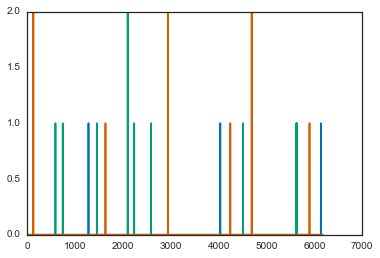

In [69]:
#each color is a question, x axis is the words, y axis is the counts (like histogram)
plt.plot(counts[:3,:].toarray().T)

In [119]:
top_words = {}
for itrg in np.unique(targets):
    cat = vec_tar.classes_[itrg]
    # Pull rows for the current category, sum all rows (each element is a word)
    icounts = counts[targets == itrg, :].sum(0).squeeze() 
    
    # Which word counts occured >5 times
    mask_top_words = icounts > 5
    
    # Turns vectors back into actual words (inverse transform - magical!)
    top_words[cat] = vec.inverse_transform(mask_top_words)[0]

In [19]:
#keep words that are unique to that category
unique_words = {}
for cat, words in zip(top_words.keys(), top_words.values()):
    others = top_words.copy()
    others.pop(cat)
    unique_words[cat] = [wrd for wrd in top_words[cat]
                         if wrd not in np.hstack(others.values())]

In [153]:
#try SVC
mod = LinearSVC(C=.1)
cv = StratifiedShuffleSplit(targets, n_iter=10, test_size=.1)

coefs, scores = [[] for i in range(2)]
for tr, tt in cv:
    mod.fit(counts[tr], targets[tr])
    coefs.append(mod.coef_)
    print(mod.score(counts[tt], targets[tt]))
    scores.append(mod.score(counts[tt],targets[tt]))
coefs = np.array(coefs).mean(0)

print('Linear SVC mean score: {0}'.format(np.mean(scores)))

0.511111111111
0.566666666667
0.537037037037
0.503703703704
0.503703703704
0.537037037037
0.525925925926
0.511111111111
0.544444444444
0.522222222222
Linear SVC mean score: 0.5262962962962963


In [154]:
#try Naive Bayes
mod = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
cv = StratifiedShuffleSplit(targets, n_iter = 10, test_size = 0.1)

coefs = []
for tr, tt in cv:
    mod.fit(counts[tr], targets[tr])
    coefs.append(mod.coef_)
    print(mod.score(counts[tt], targets[tt]))
    scores.append(mod.score(counts[tt],targets[tt]))
coefs = np.array(coefs).mean(0)

print('Naive Bayes mean score: {0}'.format(np.mean(scores)))

0.52962962963
0.57037037037
0.518518518519
0.548148148148
0.577777777778
0.562962962963
0.57037037037
0.566666666667
0.588888888889
0.581481481481
Naive Bayes mean score: 0.5438888888888889


In [146]:
#look only at highly weighted
for cat, icoef in zip(vec_tar.classes_, coefs):
    cut = np.percentile(icoef, 99)
    important = icoef > cut
    print('{0}: {1}'.format(cat, vec.inverse_transform(important)))

1: [array(['best', 'does', 'good', 'know', 'like', 'make', 'need', 'people',
       'want', 'yahoo'], 
      dtype='<U13')]
2: [array(['best', 'computer', 'does', 'know', 'use', 'want', 'web', 'windows',
       'xa', 'yahoo'], 
      dtype='<U13')]
3: [array(['best', 'did', 'does', 'favorite', 'know', 'like', 'movie', 'music',
       'song', 'xa'], 
      dtype='<U13')]
4: [array(['boyfriend', 'does', 'friend', 'girl', 'guy', 'know', 'like',
       'love', 'really', 'want'], 
      dtype='<U13')]
5: [array(['best', 'college', 'does', 'good', 'help', 'know', 'need', 'school',
       'word', 'xa'], 
      dtype='<U13')]
6: [array(['bad', 'best', 'does', 'feel', 'good', 'help', 'know', 'like',
       'pain', 'way'], 
      dtype='<U13')]
7: [array(['does', 'earth', 'gas', 'life', 'make', 'really', 'tell', 'theory',
       'world', 'xa'], 
      dtype='<U13')]
